# makemore-jax

In [1]:
import random

import numpy as np
import jax.numpy as jnp
import jax.random as jrandom

from jax import grad, value_and_grad, jit

## Data

In [2]:
with open('names.txt') as f:
    words = f.read().splitlines()

len(words)

32033

In [3]:
chars = sorted(set(''.join(words)))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

len(stoi)

27

In [4]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return np.array(X), np.array(Y)

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

len(Ytr), len(Ydev), len(Yte)

(182625, 22655, 22866)

## Model

In [24]:
d = 2
neurons = 100

key = jrandom.PRNGKey(0)
key, *subkeys = jrandom.split(key, 6)
subkeys = iter(subkeys)

C = jrandom.normal(next(subkeys), shape=(27, d))
W1 = jrandom.normal(next(subkeys), shape=(d * 3, neurons))
b1 = jrandom.normal(next(subkeys), shape=(neurons, ))
W2 = jrandom.normal(next(subkeys), shape=(neurons, 27))
b2 = jrandom.normal(next(subkeys), shape=(27, ))

parameters = [C, W1, b1, W2, b2]
sum(p.size for p in parameters)

3481

## Training

In [25]:
@jit
def loss_fn(C, W1, b1, W2, b2, X, Y):
    emb = C[X]
    h = jnp.tanh(emb.reshape((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    logits -= logits.max(1, keepdims=True)
    counts = jnp.exp(logits)
    probs = counts / counts.sum(1, keepdims=True)
    loss = -jnp.log(probs[jnp.arange(X.shape[0]), Y]).mean()
    return loss

In [30]:
@jit
def train(C, W1, b1, W2, b2, Xb, Yb):
    loss, (gC, gW1, gb1, gW2, gb2) = value_and_grad(loss_fn, argnums=(0, 1, 2, 3, 4))(C, W1, b1, W2, b2, Xb, Yb)

    C -= lr * gC
    W1 -= lr * gW1
    b1 -= lr * gb1
    W2 -= lr * gW2
    b2 -= lr * gb2
    
    return C, W1, b1, W2, b2

key = jrandom.PRNGKey(0)
lr = 0.1
for _ in range(10000):
    key, subkey = jrandom.split(key)
    ix = jrandom.randint(subkey, shape=(32,), minval=0, maxval=Xtr.shape[0])
    Xb, Yb = Xtr[ix], Ytr[ix]
    C, W1, b1, W2, b2 = train(C, W1, b1, W2, b2, Xb, Yb)

In [31]:
loss_fn(C, W1, b1, W2, b2, Xtr, Ytr), loss_fn(C, W1, b1, W2, b2, Xdev, Ydev)

(Array(2.4564648, dtype=float32), Array(2.4484122, dtype=float32))

## Visualization

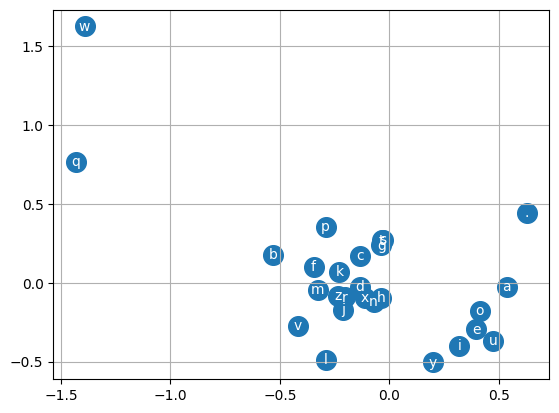

In [32]:
import matplotlib.pyplot as plt
plt.scatter(C[:, 0], C[:, 1], s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0], C[i, 1], itos[i], ha="center", va="center", color="white")
plt.grid("minor")

## Sample

In [33]:
key = jrandom.PRNGKey(0)
for _ in range(20):
    out = []
    context = [0] * 3
    while True:
        emb = C[jnp.array(context)]
        h = jnp.tanh(emb.reshape((-1, 6)) @ W1 + b1)
        logits = h @ W2 + b2
        logits -= logits.max(1, keepdims=True)
        
        key, subkey = jrandom.split(key)
        ix = jrandom.categorical(subkey, logits).item()
        
        if ix == 0:
            break
        context = context[1:] + [ix]
        out.append(ix)
    
    print("".join(itos[i] for i in out))

rur
emmyon
jeanamilla
brone
jieai
krillo
jrayle
karire
omone
carlywa
daree
homi
addelie
amro
aeum
trciezeejmir
kin
rdah
hni
tya
